In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

In [3]:
dir_root = get_project_root()
dir_data = 'data'
filename_data_brain = os.path.join(
    dir_root,
    dir_data, 
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_54215/801828396.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [4]:
data = clean_data(data_raw)

For an initial look, let's just define a list of some of the  columns that look interesting.

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [6]:
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=2984, 
    shuffle=True, 
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test , y_test  = split_X_and_y_data(data_test)

In [7]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61061 entries, 36640 to 46191
Data columns (total 128 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Sex                                                                    61061 non-null  category
 1    Year of diagnosis                                                      61061 non-null  int64   
 2    PRCDA 2020                                                             61061 non-null  object  
 3    Race recode (W, B, AI, API)                                            61061 non-null  category
 4    Origin recode NHIA (Hispanic, Non-Hisp)                                61061 non-null  category
 5    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)             61061 non-null  category
 6    TNM 7/CS v0204+ Schema (thru 2017)                                   

## Kaplan-Meier Curve

In [8]:
from lifelines import KaplanMeierFitter

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(y_train['Survival months'], event_observed=y_train['Event indicator'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 61061 total observations, 14855 right-censored observations>

Text(0.5, 0, 'Months from diagnosis')

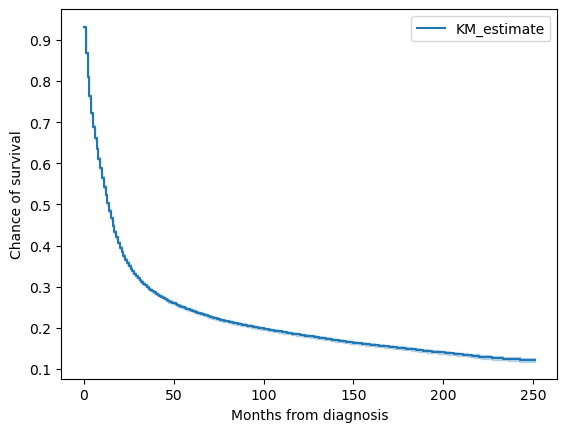

In [10]:
ax = kmf.plot_survival_function()
ax.set_ylabel('Chance of survival')
ax.set_xlabel('Months from diagnosis')

In [11]:
from lifelines.utils import median_survival_times

In [12]:
kmf.median_survival_time_

14.0

In [13]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,0.930210,0.934197
1.0,0.865059,0.870444
2.0,0.807318,0.813559
3.0,0.759197,0.765984
4.0,0.717874,0.725034
...,...,...
247.0,0.116790,0.127347
248.0,0.116790,0.127347
249.0,0.116790,0.127347
250.0,0.116790,0.127347


In [14]:
median_survival_times(kmf.confidence_interval_)

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,13.0,14.0


### Trying with multiple groups

In [15]:
def plot_km_curve(X, y, stratify_class=None) -> plt.Axes:
    '''
    Plots the Kaplan-Meier curve for the data, optionally splitting the data 
    into separate classes based on one of the columns.
    '''
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    if stratify_class is None:
        kmf.fit(
            y_train['Survival months'], 
            event_observed=y_train['Event indicator']
        )
        kmf.plot_survival_function(ax=ax)
        ax.set_title('K-M curve')
    else:
        for name, grouped_df in X_train.join(y_train).groupby(stratify_class):
            kmf.fit(
                grouped_df["Survival months"], 
                grouped_df["Event indicator"], 
                label=name
            )
            kmf.plot_survival_function(ax=ax)
            ax.set_title(f'K-M curve for values of "{stratify_class}"')
    ax.set_ylabel('Chance of survival')
    ax.set_xlabel('Months from diagnosis')
    return ax

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_54215/178472140.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X_train.join(y_train).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Sex"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

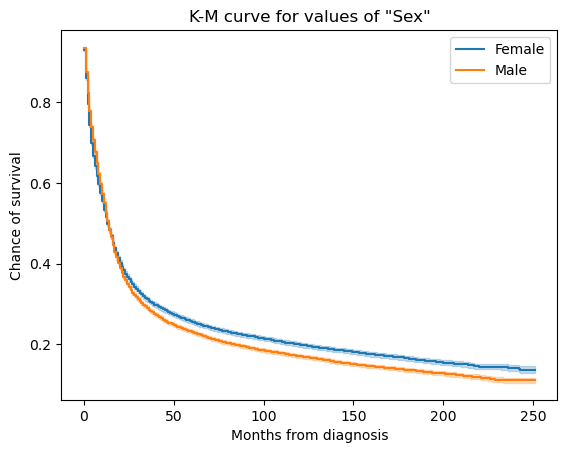

In [16]:
plot_km_curve(X_train, y_train, stratify_class='Sex')

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_54215/178472140.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X_train.join(y_train).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Race recode (W, B, AI, API)"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

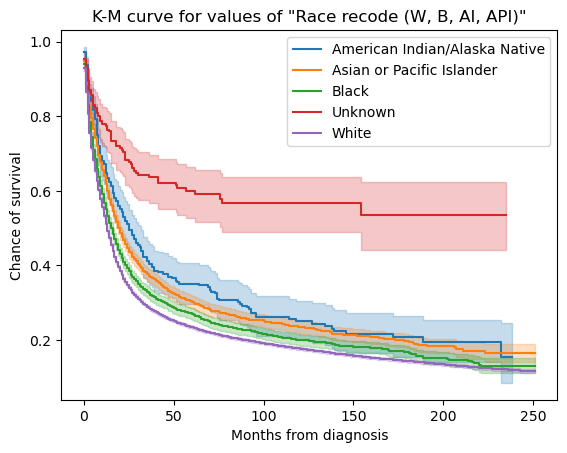

In [17]:
plot_km_curve(X_train, y_train, stratify_class='Race recode (W, B, AI, API)')

## Cox Proportional Hazards Model

### Very Simple Model Training

We only train a very simple model here and don't even preprocess features. This is just a very basic proof of concept.

In [18]:
from lifelines import CoxPHFitter

In [19]:
subset_columns = ['Age standard for survival','Year of diagnosis']
X_subset_train = X_train[subset_columns]
dd = X_subset_train.join(y_train)

In [20]:
cph = CoxPHFitter()
cph.fit(dd, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph.print_summary(decimals=3)

Iteration 1: norm_delta = 7.46e-01, step_size = 0.9500, log_lik = -476595.52777, newton_decrement = 1.17e+04, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.56e-01, step_size = 0.9500, log_lik = -464225.04289, newton_decrement = 3.80e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.73e-02, step_size = 0.9500, log_lik = -463833.55893, newton_decrement = 4.22e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.17e-04, step_size = 1.0000, log_lik = -463829.32136, newton_decrement = 1.91e-04, seconds_since_start = 0.1
Iteration 5: norm_delta = 5.36e-09, step_size = 1.0000, log_lik = -463829.32117, newton_decrement = 4.02e-13, seconds_since_start = 0.1
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -463829.321
         time fit was run = 2024-05-30 16:14:26 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
Age standard for survival  0.041     1.042     0.000           0.040           0.041               1.041               1.042
Year of diagnosis         -0.017     0.983     0.001          -0.019          -0.016               0.981               0.984

                           cmp to       z       p  -log2(p)
covariate                                                  
Age standard for survival   0.000 144.493 <0.0005       inf
Year of diagnosis           0.000 -20.520 <0.0005   308.435
---
Concordance = 0.730
Partial AIC = 927662.642
log-likelihood ratio test = 25532.413 on 2 df
-log2(p) of ll-ratio test = inf

### Training with a larger subset of columns

This requires more code because we are preprocessing the data before training now.

In [21]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder as OneHotEncoder_SKL
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from src.transformers.transformers import DataFrameTransformer, DropCollinearFeatures, DropLowVarianceConditionedOnOutcome

**Note:** We were getting `ConvergenceWarning` errors during much of the training below that were related to colinearity in the data and features that were perfectly predictive of the outcome. To address these kinds of features automatically, we added the `DropCollinearFeatures` and `DropLowVarianceConditionedOnOutcome` steps to the preprocessing pipeline. 

For reference, the problematic features were "Histologic Type ICD-O-3", "Diagnostic Confirmation", "Histology recode - broad groupings", "SEER Combined Summary Stage 2000 (2004-2017)", and "Brain Molecular Markers (2018+)".

See for more info: https://lifelines.readthedocs.io/en/stable/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model

In [23]:
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer = make_column_transformer(
    (
        StandardScaler(),
        [
            # 'Age recode with <1 year olds',
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            # should we restrict the cohort to N=1?
            "Total number of in situ/malignant tumors for patient",
            "Combined Tumor Size",
            # "No tumor found",    # was causing issues below
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Age standard for survival",  # handle standardized age groupings categorically
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            # 'AYA site recode 2020 Revision',
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            # "Histologic Type ICD-O-3",  # dropped b/c of colinearity issues
            "Grade Recode (thru 2017)",
            # "Diagnostic Confirmation",  # dropped b/c of colinearity issues
            # "Histology recode - broad groupings",  # dropped b/c of colinearity issues
            # 'SEER Combined Summary Stage 2000 (2004-2017)', # dropped b/c of colinearity issues
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            # "Brain Molecular Markers (2018+)",  # dropped b/c of colinearity issues
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer.set_output(transform='pandas')
pipeline = make_pipeline(
    column_transformer, 
    DropCollinearFeatures(threshold=0.90),
    DropLowVarianceConditionedOnOutcome(threshold=8e-1)
)

In [24]:
X_train_trans = pipeline.fit_transform(X_train, y=y_train)
dd_trans = X_train_trans.join(y_train)

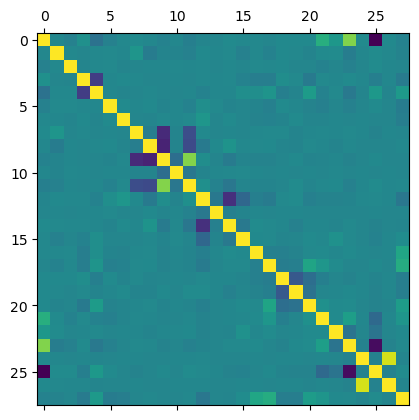

In [25]:
# Plot the data correlation matrix (after dropping highly colinear features)
plt.matshow(X_train_trans.corr())

In [26]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph.print_summary(decimals=3)

Iteration 1: norm_delta = 5.35e-01, step_size = 0.9500, log_lik = -476595.52777, newton_decrement = 4.46e+03, seconds_since_start = 0.1
Iteration 2: norm_delta = 6.22e-02, step_size = 0.9500, log_lik = -472269.81256, newton_decrement = 1.07e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 6.18e-03, step_size = 0.9500, log_lik = -472160.02407, newton_decrement = 1.06e+00, seconds_since_start = 0.2
Iteration 4: norm_delta = 7.97e-05, step_size = 1.0000, log_lik = -472158.95607, newton_decrement = 1.88e-04, seconds_since_start = 0.2
Iteration 5: norm_delta = 2.99e-08, step_size = 1.0000, log_lik = -472158.95588, newton_decrement = 3.08e-11, seconds_since_start = 0.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -472158.956
         time fit was run = 2024-05-30 16:15:09 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.068     0.934     0.007          -0.082          -0.054               0.921               0.947
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.035     0.966     0.004          -0.044          -0.026               0.957               0.974
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.107     0.899     0.005          -0.116          -0.098               0.891               0.907
standardscaler__Combined Tumor Size                                                                                                                0.042     1.043     0.003           0.035           0.049               1.036               1.050
standardscaler__Unknown tumor size                                                                                                                -0.020     0.980     0.005          -0.029          -0.011               0.971               0.989
pipeline-1__Age standard for survival=45                                                                                                          -0.078     0.925     0.004          -0.087          -0.070               0.917               0.933
pipeline-1__Sex=Male                                                                                                                               0.036     1.036     0.004           0.027           0.044               1.027               1.045
pipeline-1__Race recode (W, B, AI, API)=Asian or Pacific Islander                                                                                  0.005     1.005     0.007          -0.008           0.019               0.992               1.019
pipeline-1__Race recode (W, B, AI, API)=Black                                                                                                      0.031     1.031     0.007           0.017           0.045               1.017               1.046
pipeline-1__Race recode (W, B, AI, API)=White                                                                                                      0.026     1.026     0.009           0.009           0.043               1.009               1.044
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native                                 -0.007     0.993     0.005          -0.016           0.003               0.984               1.003
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic White                                                          0.076     1.078     0.006           0.064           0.087               1.067               1.090
pipeline-1__Marital status at diagnosis=Married (including common law)                                              

In [27]:
cph.params_.abs().sort_values(ascending=False)[:9]

covariate
pipeline-1__Marital status at diagnosis=Single (never married)                                                                                       0.308117
pipeline-2__missingindicator_Months from diagnosis to treatment                                                                                      0.229255
pipeline-1__Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)=Not documented; Cannot be determined; Not assessed or unknown if assessed    0.162002
pipeline-1__Marital status at diagnosis=Married (including common law)                                                                               0.133518
pipeline-1__SEER Brain and CNS Recode=1.1.9 Glioma, unspecified                                                                                      0.129398
standardscaler__Total number of in situ/malignant tumors for patient                                                                                 0.106644
pipeline-1__Chromosome 19q: Loss of Hetero

In [28]:
events = dd_trans['Event indicator'].astype(bool)

# Prepare a dictionary to store the variances
variances = {
    'column': [],
    'variance_event_true': [],
    'variance_event_false': []
}

# Iterate over columns to compute variances conditioned on the event
for col in dd_trans.columns:
    if col == 'Event indicator':
        continue
    
    var_true = dd_trans.loc[events, col].var()
    var_false = dd_trans.loc[~events, col].var()
    
    variances['column'].append(col)
    variances['variance_event_true'].append(var_true)
    variances['variance_event_false'].append(var_false)

# Convert the variances dictionary to a DataFrame for better visualization
variances_df = pd.DataFrame(variances)

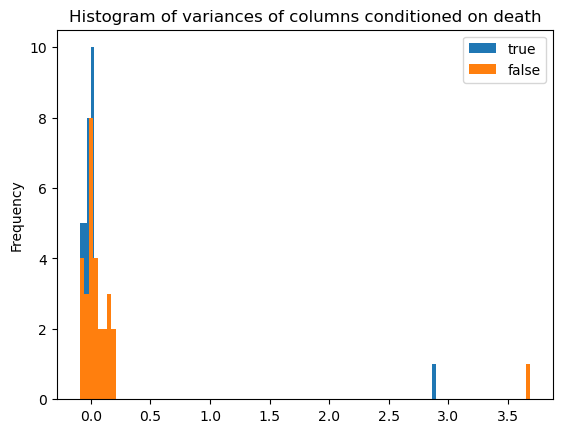

In [29]:
fig, ax = plt.subplots()
vet = np.log10(variances_df['variance_event_true'].sort_values()).replace(-np.inf, np.nan).dropna()
vef = np.log10(variances_df['variance_event_false'].sort_values()).replace(-np.inf, np.nan).dropna()
vet.plot.hist(ax=ax, bins=100, label='true')
vef.plot.hist(ax=ax, bins=100, label='false')
ax.set_title('Histogram of variances of columns conditioned on death')
ax.legend()

In [30]:
cph2 = CoxPHFitter(penalizer=0.00001)
cph2.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph2.print_summary(decimals=3)

Iteration 1: norm_delta = 7.87e-01, step_size = 0.9500, log_lik = -476595.52777, newton_decrement = 5.70e+03, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.96e-01, step_size = 0.9500, log_lik = -471297.93684, newton_decrement = 2.99e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 3.29e-02, step_size = 0.9500, log_lik = -470990.07188, newton_decrement = 4.11e+00, seconds_since_start = 0.2
Iteration 4: norm_delta = 9.81e-04, step_size = 1.0000, log_lik = -470985.90417, newton_decrement = 3.47e-03, seconds_since_start = 0.2
Iteration 5: norm_delta = 1.14e-06, step_size = 1.0000, log_lik = -470985.90070, newton_decrement = 1.81e-08, seconds_since_start = 0.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 1e-05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -470985.901
         time fit was run = 2024-05-30 16:15:11 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.052     0.949     0.010          -0.071          -0.033               0.932               0.968
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.035     0.965     0.005          -0.044          -0.026               0.957               0.974
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.124     0.884     0.005          -0.134          -0.113               0.875               0.893
standardscaler__Combined Tumor Size                                                                                                                0.045     1.046     0.004           0.038           0.052               1.039               1.053
standardscaler__Unknown tumor size                                                                                                                -0.026     0.974     0.005          -0.036          -0.016               0.965               0.984
pipeline-1__Age standard for survival=45                                                                                                          -0.090     0.914     0.005          -0.099          -0.080               0.906               0.923
pipeline-1__Sex=Male                                                                                                                               0.054     1.055     0.005           0.045           0.063               1.046               1.065
pipeline-1__Race recode (W, B, AI, API)=Asian or Pacific Islander                                                                                  0.150     1.161     0.022           0.106           0.193               1.112               1.213
pipeline-1__Race recode (W, B, AI, API)=Black                                                                                                      0.182     1.199     0.023           0.137           0.227               1.146               1.255
pipeline-1__Race recode (W, B, AI, API)=White                                                                                                      0.225     1.252     0.032           0.162           0.287               1.176               1.332
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native                                  0.036     1.037     0.008           0.020           0.053               1.020               1.054
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic White                                                          0.084     1.087     0.007           0.071           0.097               1.073               1.101
pipeline-1__Marital status at diagnosis=Married (including common law)                                            

In [31]:
cph2 = CoxPHFitter(penalizer=1e-3, l1_ratio=0.5)
cph2.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph2.print_summary(decimals=3)

Iteration 1: norm_delta = 7.82e-01, step_size = 0.9500, log_lik = -477507.12721, newton_decrement = 5.69e+03, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.84e-01, step_size = 0.9500, log_lik = -472011.97294, newton_decrement = 2.94e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 2.34e-02, step_size = 0.9500, log_lik = -471549.62673, newton_decrement = 3.89e+00, seconds_since_start = 0.2
Iteration 4: norm_delta = 4.41e-03, step_size = 1.0000, log_lik = -471424.19205, newton_decrement = 1.07e-02, seconds_since_start = 0.2
Iteration 5: norm_delta = 5.68e-03, step_size = 1.0000, log_lik = -471332.14286, newton_decrement = 1.27e-02, seconds_since_start = 0.3
Iteration 6: norm_delta = 6.80e-03, step_size = 0.9800, log_lik = -471262.98019, newton_decrement = 1.84e-02, seconds_since_start = 0.3
Iteration 7: norm_delta = 7.90e-03, step_size = 0.9604, log_lik = -471211.59927, newton_decrement = 2.48e-02, seconds_since_start = 0.4
Iteration 8: norm_delta = 8.81e-03, step_size = 

<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -471089.956
         time fit was run = 2024-05-30 16:15:13 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.052     0.949     0.010          -0.071          -0.033               0.931               0.967
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.035     0.966     0.005          -0.044          -0.026               0.957               0.975
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.123     0.884     0.005          -0.133          -0.112               0.875               0.894
standardscaler__Combined Tumor Size                                                                                                                0.045     1.046     0.004           0.038           0.052               1.039               1.053
standardscaler__Unknown tumor size                                                                                                                -0.025     0.975     0.005          -0.035          -0.015               0.965               0.985
pipeline-1__Age standard for survival=45                                                                                                          -0.089     0.915     0.005          -0.098          -0.080               0.906               0.923
pipeline-1__Sex=Male                                                                                                                               0.053     1.054     0.005           0.043           0.062               1.044               1.064
pipeline-1__Race recode (W, B, AI, API)=Asian or Pacific Islander                                                                                  0.095     1.100     0.019           0.057           0.133               1.059               1.142
pipeline-1__Race recode (W, B, AI, API)=Black                                                                                                      0.125     1.133     0.020           0.086           0.165               1.089               1.179
pipeline-1__Race recode (W, B, AI, API)=White                                                                                                      0.147     1.158     0.028           0.092           0.201               1.097               1.223
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native                                  0.019     1.019     0.008           0.004           0.034               1.004               1.034
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic White                                                          0.084     1.087     0.007           0.071           0.096               1.073               1.101
pipeline-1__Marital status at diagnosis=Married (including common law)                                            

In [32]:
cph3 = CoxPHFitter(penalizer=1e-7, l1_ratio=0.5)
cph3.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph3.print_summary(decimals=3)

Iteration 1: norm_delta = 7.87e-01, step_size = 0.9500, log_lik = -476595.61893, newton_decrement = 5.70e+03, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.96e-01, step_size = 0.9500, log_lik = -471297.86920, newton_decrement = 2.99e+02, seconds_since_start = 0.1
Iteration 3: norm_delta = 3.30e-02, step_size = 0.9500, log_lik = -470989.92760, newton_decrement = 4.11e+00, seconds_since_start = 0.2
Iteration 4: norm_delta = 9.88e-04, step_size = 1.0000, log_lik = -470985.74565, newton_decrement = 3.47e-03, seconds_since_start = 0.2
Iteration 5: norm_delta = 7.63e-07, step_size = 1.0000, log_lik = -470985.73299, newton_decrement = 1.80e-08, seconds_since_start = 0.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 1e-07
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -470985.733
         time fit was run = 2024-05-30 16:15:15 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.052     0.950     0.010          -0.071          -0.033               0.932               0.968
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.035     0.965     0.005          -0.044          -0.026               0.957               0.974
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.124     0.884     0.005          -0.134          -0.113               0.875               0.893
standardscaler__Combined Tumor Size                                                                                                                0.045     1.046     0.004           0.038           0.052               1.039               1.053
standardscaler__Unknown tumor size                                                                                                                -0.026     0.974     0.005          -0.036          -0.016               0.965               0.984
pipeline-1__Age standard for survival=45                                                                                                          -0.090     0.914     0.005          -0.099          -0.080               0.906               0.923
pipeline-1__Sex=Male                                                                                                                               0.054     1.055     0.005           0.045           0.063               1.046               1.065
pipeline-1__Race recode (W, B, AI, API)=Asian or Pacific Islander                                                                                  0.150     1.162     0.022           0.106           0.194               1.112               1.214
pipeline-1__Race recode (W, B, AI, API)=Black                                                                                                      0.182     1.200     0.023           0.137           0.227               1.147               1.255
pipeline-1__Race recode (W, B, AI, API)=White                                                                                                      0.225     1.252     0.032           0.162           0.287               1.176               1.333
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native                                  0.036     1.037     0.008           0.020           0.053               1.020               1.054
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic White                                                          0.084     1.087     0.007           0.071           0.097               1.073               1.101
pipeline-1__Marital status at diagnosis=Married (including common law)                                            

### Cross-validation

In [33]:
from lifelines.utils import k_fold_cross_validation

Getting things working with a tiny grid

In [34]:
# Define the grid
grid_penalizer = np.logspace(-1, 1, 2),
grid_l1_ratio  = np.linspace(0.01, 0.99, 2)
mg = np.meshgrid(grid_penalizer, grid_l1_ratio)
grid_points = np.vstack((mg[0].flatten(), mg[1].flatten())).T

fitters = []
for penalizer,l1_ratio in grid_points:
    print(f'(penalizer, l1_ratio) = ({penalizer}, {l1_ratio})')
    fitters.append(CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio))
    
results = k_fold_cross_validation(
    fitters, 
    dd_trans, 
    duration_col='Survival months', 
    event_col='Event indicator', 
    k=3, 
    scoring_method='concordance_index', 
    seed=8971, 
    fitter_kwargs=dict(show_progress=False)
)

(penalizer, l1_ratio) = (0.1, 0.01)
(penalizer, l1_ratio) = (10.0, 0.01)
(penalizer, l1_ratio) = (0.1, 0.99)
(penalizer, l1_ratio) = (10.0, 0.99)


In [35]:
list(zip(grid_points,np.mean(results, axis=1)))

[(array([0.1 , 0.01]), 0.6622105877984305),
 (array([10.  ,  0.01]), 0.6336955035734196),
 (array([0.1 , 0.99]), 0.6383280244249517),
 (array([10.  ,  0.99]), 0.6359887562511165)]

Trying with a larger grid

In [ ]:
# Define the grid
grid_penalizer = np.logspace(-7, 2, 10),
grid_l1_ratio  = np.linspace(0.0, 1.0, 5)
mg = np.meshgrid(grid_penalizer, grid_l1_ratio)
grid_points = np.vstack((mg[0].flatten(), mg[1].flatten())).T

fitters = []
for penalizer,l1_ratio in grid_points:
    print(f'(penalizer, l1_ratio) = ({penalizer}, {l1_ratio})')
    fitters.append(CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio))
    
results = k_fold_cross_validation(
    fitters, 
    dd_trans, 
    duration_col='Survival months', 
    event_col='Event indicator', 
    k=3, 
    scoring_method='concordance_index', 
    seed=8971, 
    fitter_kwargs=dict(show_progress=False)
)

In [ ]:
grid_scores = list(zip(grid_points,np.mean(results, axis=1)))
grid_scores[np.argmax(np.mean(results, axis=1))]

(array([0.01, 0.  ]), 0.6628957299435992)

Now let's try introducing some of the features that were excluded above.

In [73]:
def kfold_cv_train_grid(data, grid_penalizer, grid_l1_ratio, k, scoring_method='concordance_index', 
    seed=8971, fitter_kwargs=None):
    '''
    Performs a K-fold cross-validation of the data using a CoxPHFitter over the 
    specified grid of penalizer and l1_ratio points.
    '''
    mg = np.meshgrid(grid_penalizer, grid_l1_ratio)
    grid_points = np.vstack((mg[0].flatten(), mg[1].flatten())).T
    print(f'Training {k=} folds over {len(grid_points)} grid points.')

    fitters = []
    for penalizer,l1_ratio in grid_points:
        print(f'(penalizer, l1_ratio) = ({penalizer}, {l1_ratio})')
        fitters.append(CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio))
        
    scores = k_fold_cross_validation(
        fitters, 
        data, 
        duration_col='Survival months', 
        event_col='Event indicator', 
        k=k, 
        scoring_method=scoring_method, 
        seed=seed, 
        fitter_kwargs=fitter_kwargs
    )
    scores = np.array(scores)
    results = pd.DataFrame.from_dict({
        'penalizer': grid_points[:,0],
        'l1_ratio': grid_points[:,1],
        'score0': scores[:,0],
        'score1': scores[:,1],
        'score2': scores[:,2],
        'score_mean': scores.mean(axis=1)
    })
    return results

def get_best_model_from_kfold_results(results: pd.DataFrame, print_results: bool=True) -> pd.Series:
    model_best = results.iloc[results['score_mean'].idxmax()]
    if print_results:
        print('\nBest model:')
        print(f'  penalizer:  {model_best['penalizer']}')
        print(f'  l1_ratio:   {model_best['l1_ratio']}')
        print(f'  score_mean: {model_best['score_mean']}')
    return model_best

In [95]:
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder_SKL(handle_unknown="ignore", min_frequency=50, sparse_output=False),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)


column_transformer2 = make_column_transformer(
    (
        StandardScaler(),
        [
            # 'Age recode with <1 year olds',
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            # should we restrict the cohort to N=1?
            "Total number of in situ/malignant tumors for patient",
            "Combined Tumor Size",
            # "No tumor found",    # was causing issues below
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Age standard for survival",  # handle standardized age groupings categorically
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            # 'AYA site recode 2020 Revision',
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3",  # dropped b/c of colinearity issues
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation",  # dropped b/c of colinearity issues
            "Histology recode - broad groupings",  # dropped b/c of colinearity issues
            'SEER Combined Summary Stage 2000 (2004-2017)', # dropped b/c of colinearity issues
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)",  # dropped b/c of colinearity issues
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer2.set_output(transform='pandas')
pipeline2 = make_pipeline(
    column_transformer2, 
    DropCollinearFeatures(threshold=0.95, verbose=True),
    # DropLowVarianceConditionedOnOutcome(threshold=1e-2, verbose=True)
)

X_train_trans2 = pipeline2.fit_transform(X_train, y=y_train)
dd_trans2 = X_train_trans2.join(y_train)

Columns dropped due to colinearity:
  pipeline-1__Sex_Male
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic American Indian/Alaska Native
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black
  pipeline-1__Histologic Type ICD-O-3_9380
  pipeline-1__Histologic Type ICD-O-3_9382
  pipeline-1__Histologic Type ICD-O-3_9385
  pipeline-1__Histologic Type ICD-O-3_9440
  pipeline-1__Histologic Type ICD-O-3_9505
  pipeline-1__Histology recode - broad groupings_8000-8009: unspecified neoplasms
  pipeline-1__Histology recode - broad groupings_9380-9489: gliomas
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not applicable: Information not collected for this case
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not documented; Cannot be determined; Not assessed or 

In [96]:
print('Number of features in old and new data preprocessing:')
print(f'  {len(dd_trans.columns)=}')
print(f'  {len(dd_trans2.columns)=}')

Number of features in old and new data preprocessing:
  len(dd_trans.columns)=30
  len(dd_trans2.columns)=116


Training on a very small hyperparameter grid with a subset of the data (for testing purposes).

In [97]:
results = kfold_cv_train_grid(
    dd_trans2.sample(20000, random_state=2864),
    grid_penalizer=np.logspace(-4, 2, 2),
    grid_l1_ratio=np.linspace(0.0, 1.0, 2),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.5))
)
result_best = get_best_model_from_kfold_results(results)

Training k=3 folds over 4 grid points.
(penalizer, l1_ratio) = (0.0001, 0.0)
(penalizer, l1_ratio) = (100.0, 0.0)
(penalizer, l1_ratio) = (0.0001, 1.0)
(penalizer, l1_ratio) = (100.0, 1.0)

Best model:
  penalizer:  0.0001
  l1_ratio:   1.0
  score_mean: 0.7773281311745683


Trying with a larger grid, but still not the entire dataset.

In [98]:
results3 = kfold_cv_train_grid(
    dd_trans2.sample(20000, random_state=2864),
    grid_penalizer=np.logspace(-4, 2, 7),
    grid_l1_ratio=np.linspace(0.0, 1.0, 5),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.3))
)
result_best3 = get_best_model_from_kfold_results(results3)

Training k=3 folds over 35 grid points.
(penalizer, l1_ratio) = (0.0001, 0.0)
(penalizer, l1_ratio) = (0.001, 0.0)
(penalizer, l1_ratio) = (0.01, 0.0)
(penalizer, l1_ratio) = (0.1, 0.0)
(penalizer, l1_ratio) = (1.0, 0.0)
(penalizer, l1_ratio) = (10.0, 0.0)
(penalizer, l1_ratio) = (100.0, 0.0)
(penalizer, l1_ratio) = (0.0001, 0.25)
(penalizer, l1_ratio) = (0.001, 0.25)
(penalizer, l1_ratio) = (0.01, 0.25)
(penalizer, l1_ratio) = (0.1, 0.25)
(penalizer, l1_ratio) = (1.0, 0.25)
(penalizer, l1_ratio) = (10.0, 0.25)
(penalizer, l1_ratio) = (100.0, 0.25)
(penalizer, l1_ratio) = (0.0001, 0.5)
(penalizer, l1_ratio) = (0.001, 0.5)
(penalizer, l1_ratio) = (0.01, 0.5)
(penalizer, l1_ratio) = (0.1, 0.5)
(penalizer, l1_ratio) = (1.0, 0.5)
(penalizer, l1_ratio) = (10.0, 0.5)
(penalizer, l1_ratio) = (100.0, 0.5)
(penalizer, l1_ratio) = (0.0001, 0.75)
(penalizer, l1_ratio) = (0.001, 0.75)
(penalizer, l1_ratio) = (0.01, 0.75)
(penalizer, l1_ratio) = (0.1, 0.75)
(penalizer, l1_ratio) = (1.0, 0.75)
(pena

Training on the full dataset with all of the previously excluded columns.

In [101]:
results2 = kfold_cv_train_grid(
    dd_trans2,
    grid_penalizer=np.logspace(-4, 2, 7),
    grid_l1_ratio=np.linspace(0.0, 1.0, 5),
    k=3,
    fitter_kwargs=dict(fit_options=dict(step_size=0.5))
)
result_best2 = get_best_model_from_kfold_results(results2)

Training k=3 folds over 35 grid points.
(penalizer, l1_ratio) = (0.0001, 0.0)
(penalizer, l1_ratio) = (0.001, 0.0)
(penalizer, l1_ratio) = (0.01, 0.0)
(penalizer, l1_ratio) = (0.1, 0.0)
(penalizer, l1_ratio) = (1.0, 0.0)
(penalizer, l1_ratio) = (10.0, 0.0)
(penalizer, l1_ratio) = (100.0, 0.0)
(penalizer, l1_ratio) = (0.0001, 0.25)
(penalizer, l1_ratio) = (0.001, 0.25)
(penalizer, l1_ratio) = (0.01, 0.25)
(penalizer, l1_ratio) = (0.1, 0.25)
(penalizer, l1_ratio) = (1.0, 0.25)
(penalizer, l1_ratio) = (10.0, 0.25)
(penalizer, l1_ratio) = (100.0, 0.25)
(penalizer, l1_ratio) = (0.0001, 0.5)
(penalizer, l1_ratio) = (0.001, 0.5)
(penalizer, l1_ratio) = (0.01, 0.5)
(penalizer, l1_ratio) = (0.1, 0.5)
(penalizer, l1_ratio) = (1.0, 0.5)
(penalizer, l1_ratio) = (10.0, 0.5)
(penalizer, l1_ratio) = (100.0, 0.5)
(penalizer, l1_ratio) = (0.0001, 0.75)
(penalizer, l1_ratio) = (0.001, 0.75)
(penalizer, l1_ratio) = (0.01, 0.75)
(penalizer, l1_ratio) = (0.1, 0.75)
(penalizer, l1_ratio) = (1.0, 0.75)
(pena

In [103]:
cph_best = CoxPHFitter(penalizer=result_best3.penalizer, l1_ratio=result_best3.l1_ratio)
cph_best.fit(dd_trans2, duration_col='Survival months', event_col='Event indicator', show_progress=True)
cph_best.print_summary(decimals=3)

Iteration 1: norm_delta = 8.85e-01, step_size = 0.9500, log_lik = -484018.55183, newton_decrement = 2.09e+04, seconds_since_start = 1.2
Iteration 2: norm_delta = 3.08e-01, step_size = 0.9500, log_lik = -464797.06875, newton_decrement = 3.25e+03, seconds_since_start = 1.8
Iteration 3: norm_delta = 9.23e-02, step_size = 0.9500, log_lik = -460112.12565, newton_decrement = 1.08e+02, seconds_since_start = 2.2
Iteration 4: norm_delta = 3.81e-02, step_size = 1.0000, log_lik = -458988.55576, newton_decrement = 3.95e+00, seconds_since_start = 2.7
Iteration 5: norm_delta = 1.45e-02, step_size = 1.0000, log_lik = -458213.00769, newton_decrement = 7.89e-02, seconds_since_start = 3.2
Iteration 6: norm_delta = 1.50e-02, step_size = 1.0000, log_lik = -457623.46182, newton_decrement = 4.02e-02, seconds_since_start = 3.7
Iteration 7: norm_delta = 2.02e-02, step_size = 0.9800, log_lik = -457174.34756, newton_decrement = 6.60e-02, seconds_since_start = 4.2
Iteration 8: norm_delta = 2.94e-02, step_size = 

<lifelines.CoxPHFitter: fitted with 61061 total observations, 14855 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 61061
number of events observed = 46206
   partial log-likelihood = -455863.144
         time fit was run = 2024-05-30 18:55:00 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Year of diagnosis                                                                                                                 -0.072     0.931     0.009          -0.089          -0.055               0.915               0.947
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.057     0.944     0.005          -0.066          -0.048               0.936               0.953
standardscaler__Total number of in situ/malignant tumors for patient                                                                              -0.098     0.907     0.005          -0.108          -0.088               0.898               0.916
standardscaler__Combined Tumor Size                                                                                                                0.038     1.039     0.004           0.030           0.046               1.031               1.048
standardscaler__Unknown tumor size                                                                                                                 0.028     1.028     0.006           0.017           0.038               1.017               1.039
pipeline-1__Age standard for survival_15                                                                                                          -0.411     0.663     0.008          -0.426          -0.396               0.653               0.673
pipeline-1__Age standard for survival_45                                                                                                          -0.123     0.885     0.006          -0.134          -0.112               0.875               0.894
pipeline-1__Age standard for survival_55                                                                                                           0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Age standard for survival_65                                                                                                           0.136     1.145     0.005           0.125           0.146               1.133               1.157
pipeline-1__Age standard for survival_75                                                                                                           0.330     1.391     0.006           0.319           0.341               1.376               1.407
pipeline-1__Sex_Female                                                                                                                            -0.059     0.943     0.005          -0.068          -0.050               0.934               0.952
pipeline-1__Race recode (W, B, AI, API)_American Indian/Alaska Native                                                                             -0.002     0.998     0.005          -0.012           0.008               0.988               1.008
pipeline-1__Race recode (W, B, AI, API)_Asian or Pacific Islander                                                 